# Case study 6 - AC

Changes in the first code block compared to the second:

- Utilizes an Actor-Critic model instead of simple neural networks for classification.
- Defines the actionsDictionary both globally and within the CancerTreatmentEnv class.
- Incorporates an environment class (CancerTreatmentEnv) to simulate interactions.
- Includes a method (train_actor_critic) for training the Actor-Critic model using environment interactions.
- Uses torch.optim as the optimizer instead of SGD.
- Employs a reward function that considers tumor reduction weight and toxicity penalty weight.

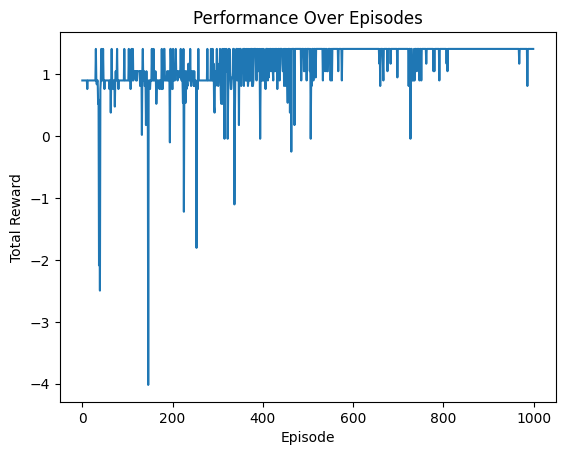

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import scipy.integrate as integrate
import matplotlib.pyplot as plt


num_states = 2
numberOfActions = 4
actionsDictionary = {
    0: 0.1,  # Low Intensity Treatment
    1: 0.4,  # Medium Intensity Treatment
    2: 0.7,  # High Intensity Treatment
    3: 1.0   # Very High Intensity Treatment
}
classifiers = {}
rng = np.random.default_rng()


class ActorCritic(nn.Module):
    def __init__(self, num_states, num_actions):
        super(ActorCritic, self).__init__()
        self.common = nn.Linear(num_states, 128)
        self.actor = nn.Linear(128, num_actions)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.common(x))
        action_probs = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_probs, state_values


class CancerTreatmentEnv:
    def __init__(self):
        # initializations, adjust based on your simulation details
        self.num_states = 2
        self.num_actions = 4  # number of different treatment actions

        # Initialize state variables, e.g., XState for toxicity, YState for tumor size
        self.XState = 0.5  # Starting toxicity level
        self.YState = 0.5  # Starting tumor size

        self.toxicity_threshold = 0.8
        self.tumor_size_threshold = 0.2

        # Define action space, different treatment intensities
        self.actionsDictionary = {
            0: 0.1,  # Low Intensity Treatment
            1: 0.4,  # Medium Intensity Treatment
            2: 0.7,  # High Intensity Treatment
            3: 1.0   # Very High Intensity Treatment
        }

    def reset(self):
        # Reset the environment to the initial state
        self.XState = 0.5  # Reset toxicity level
        self.YState = 0.5  # Reset tumor size
        return np.array([self.XState, self.YState])

    def step(self, action):

        # Update state variables using simulate1Step function
        self.XState, self.YState = simulate1Step(self.XState, self.YState, self.XState, self.YState, action)

        # Parameters to weigh the importance of tumor size reduction and toxicity control
        tumor_reduction_weight = 2
        toxicity_penalty_weight = 1

        # Adjusted reward function to have preferences here
        reward = tumor_reduction_weight * max(0, 1 - self.YState) - toxicity_penalty_weight * self.XState

        #episode ends if toxicity exceeds a threshold or tumor size is sufficiently reduced
        done = self.XState > self.toxicity_threshold or self.YState < self.tumor_size_threshold

        return np.array([self.XState, self.YState]), reward, done, {}


# Below are the constants used in the simulations of the cancer treatement plan
a1 = 0.15
a2 = 0.1
b1 = 1.2
b2 = 1.2
c0 = -4
c1 = 1
c2 = 1
d1 = 0.5
d2 = 0.5


# Below is just adding the deltas to the states, for 1 time step
def deltaX(XState, YState, initialYState, actionIndex):
  return a2 * np.maximum(YState, initialYState) + b2 * (actionsDictionary[actionIndex] - d2)

def deltaY(XState, YState, initialXState, actionIndex):
  if(YState > 0):
    indicatorFunctionResult = 1
  else:
    indicatorFunctionResult = 0
  actionsDictionary[actionIndex]
  np.maximum(XState, initialXState)
  return (a1 * np.maximum(XState, initialXState) - b1 * (actionsDictionary[actionIndex] - d1)) * indicatorFunctionResult

def simulate1Step(
    XState, YState, initialXState, initialYState, actionIndex
  ):
  # args: index of an action that corresponds to the amount of chemical given to the patient



  return (XState + deltaX(XState, YState, initialYState, actionIndex), YState + deltaY(XState, YState, initialXState, actionIndex))


# Below is the function that returns (0) if the patient has died during the present point in time in the simulation. If the patient lives, it returns 1
def checkLifeStatus(previousXState, previousYState, presentXState, presentYState):

  def XAsAFunctionOfTime(time):
    return previousXState + time * (presentXState - previousXState)

  def YAsAFunctionOfTime(time):
    return previousYState + time * (presentYState - previousYState)

  def lambdaAsAFunctionOfTime(time):
    return np.exp(c0 + c1 * YAsAFunctionOfTime(time) + c2 * XAsAFunctionOfTime(time))

  lambdaIntegral = integrate.quad(lambdaAsAFunctionOfTime, 0, 1)[0]

  probabilityOfDeath = 1 - np.exp(-lambdaIntegral)

  if(rng.random() < probabilityOfDeath):
    return 0
  else:
    return 1



def evaluatePreference(
    XState, YState, initialXState, initialYState,
    actionIndex1, actionIndex2, timeIndex, policy
  ):

  maximumToxicityWithActionIndex1 = XState
  maximumToxicityWithActionIndex2 = XState

  previousXStateWithActionIndex1 = XState
  previousXStateWithActionIndex2 = XState

  previousYStateWithActionIndex1 = YState
  previousYStateWithActionIndex2 = YState

  # We simulate (1) time step here:

  (XStateWithActionIndex1, YStateWithActionIndex1) = simulate1Step(XState, YState, initialXState, initialYState, actionIndex1)

  (XStateWithActionIndex2, YStateWithActionIndex2) = simulate1Step(XState, YState, initialXState, initialYState, actionIndex2)


  # We check the life status here:
  lifeStatusWithActionIndex1 = checkLifeStatus(previousXStateWithActionIndex1, previousYStateWithActionIndex1, XStateWithActionIndex1, YStateWithActionIndex1)
  lifeStatusWithActionIndex2 = checkLifeStatus(previousXStateWithActionIndex2, previousYStateWithActionIndex2, XStateWithActionIndex2, YStateWithActionIndex2)

  # If the patient has died for (1) of the actions, then the following logic gives the pareto dominance relationship:
  if(lifeStatusWithActionIndex2 > lifeStatusWithActionIndex1):
    return 1
  elif(lifeStatusWithActionIndex2 < lifeStatusWithActionIndex1):
    return -1
  elif((lifeStatusWithActionIndex2 == 0) and (lifeStatusWithActionIndex1 == 0)):
    return 0

  # We store the maximum toxicity here, that tells us about pareto dominance:
  maximumToxicityWithActionIndex1 = np.maximum(maximumToxicityWithActionIndex1, XStateWithActionIndex1)
  maximumToxicityWithActionIndex2 = np.maximum(maximumToxicityWithActionIndex2, XStateWithActionIndex2)


  timeIndex = timeIndex + 1

  # The following are the remaining time steps in the simulation; they follow the same logic are previously described
  while(timeIndex < 6):

    # The remaining action indices are chosen according to the policy in all remaining simulation steps:
    actionIndex1 = policy(classifiers, XStateWithActionIndex1, YStateWithActionIndex1)
    actionIndex2 = policy(classifiers, XStateWithActionIndex2, YStateWithActionIndex2)

    # We always store the state X and Y for each action indices. (ActionIndex1) and (ActionIndex2) correspond to the initial action taken at the beginning that have to be compared
    previousXStateWithActionIndex1 = XStateWithActionIndex1
    previousXStateWithActionIndex2 = XStateWithActionIndex2

    previousYStateWithActionIndex1 = YStateWithActionIndex1
    previousYStateWithActionIndex2 = YStateWithActionIndex2

    (XStateWithActionIndex1, YStateWithActionIndex1) = simulate1Step(XStateWithActionIndex1, YStateWithActionIndex1, initialXState, initialYState, actionIndex1)
    (XStateWithActionIndex2, YStateWithActionIndex2) = simulate1Step(XStateWithActionIndex2, YStateWithActionIndex2, initialXState, initialYState, actionIndex2)

    lifeStatusWithActionIndex1 = checkLifeStatus(previousXStateWithActionIndex1, previousYStateWithActionIndex1, XStateWithActionIndex1, YStateWithActionIndex1)
    lifeStatusWithActionIndex2 = checkLifeStatus(previousXStateWithActionIndex2, previousYStateWithActionIndex2, XStateWithActionIndex2, YStateWithActionIndex2)

    if(lifeStatusWithActionIndex2 > lifeStatusWithActionIndex1):
      return 1
    elif(lifeStatusWithActionIndex2 < lifeStatusWithActionIndex1):
      return -1
    elif((lifeStatusWithActionIndex2 == 0) and (lifeStatusWithActionIndex1 == 0)):
      return 0

    maximumToxicityWithActionIndex1 = np.maximum(maximumToxicityWithActionIndex1, XStateWithActionIndex1)
    maximumToxicityWithActionIndex2 = np.maximum(maximumToxicityWithActionIndex2, XStateWithActionIndex2)

    timeIndex = timeIndex + 1

  tumorSizeAtTheEndWithActionIndex1 = YStateWithActionIndex1
  tumorSizeAtTheEndWithActionIndex2 = YStateWithActionIndex2

  # The following logic describes the pareto dominance relationship when the patient has survived under the 2 choices of initial actions:
  if((tumorSizeAtTheEndWithActionIndex2 < tumorSizeAtTheEndWithActionIndex1) and (maximumToxicityWithActionIndex2 < maximumToxicityWithActionIndex1)):
    return 1
  elif((tumorSizeAtTheEndWithActionIndex1 < tumorSizeAtTheEndWithActionIndex2) and (maximumToxicityWithActionIndex1 < maximumToxicityWithActionIndex2)):
    return -1
  else:
    return 0


# This is the construction of the policy with the pair-wise classifiers
def policy(classifiers, XState, YState):

  # We first choose a random index:
  randomInitialActionIndex = np.random.randint(numberOfActions)
  bestActionIndex = randomInitialActionIndex

  # (actionIndicesToCheck) gives the series of actions to check successively to find the best action
  actionIndicesToCheck = [0, 1, 2, 3]
  actionIndicesToCheck.remove(bestActionIndex)

  # (classifiersAppliedOnTheStateChoices) is a dictionary containing the classifiers applied on the input state (XState, YState)
  # The results are going to be used to classify the actions
  classifiersAppliedOnTheStateChoices = {}

  for actionIndex1 in range(numberOfActions):
    for actionIndex2 in range(actionIndex1 + 1, numberOfActions):

      classifier = classifiers[(actionIndex1, actionIndex2)]

      # The best action is given by taking the argmax of the classifier applied on the state. A value of (0) means that, for the classifier at hand,
      # (actionIndex1) is pareto dominant to (actionIndex2). A value of (1) give the opposite dominance
      classifiersAppliedOnTheStateChoices[(actionIndex1, actionIndex2)] = torch.argmax(classifier(torch.Tensor([[XState, YState]]))).cpu().numpy()

  for actionIndexToCheck in actionIndicesToCheck:

    # (bestActionIndex) is checked against all possibilities of (actionIndexToCheck) in (actionIndicesToCheck)
    # The key (bestActionIndex, actionIndexToCheck) might not correspond to a classifier in the classifiers dictionary, because switching the 2 indices would have just given the reversed classifier.
    # Since we might not have learned the classifier corresponding to (bestActionIndex, actionIndexToCheck), because of symmetry, we first check we have it in the outer (if) statement
    if (bestActionIndex, actionIndexToCheck) in classifiersAppliedOnTheStateChoices:

      # The following means that actionIndexToCheck is pareto dominant to the previous bestActionIndex. So we store it, and continue the outer (for) loop for the other actionIndicesToCheck.
      # We do this until we have verified all actions and found the dominant one
        if(classifiersAppliedOnTheStateChoices[(bestActionIndex, actionIndexToCheck)] == 1):

          bestActionIndex = actionIndexToCheck
    else:
      if(classifiersAppliedOnTheStateChoices[(actionIndexToCheck, bestActionIndex)] == 0):

          bestActionIndex = actionIndexToCheck
  return bestActionIndex


def train_actor_critic(actor_critic_model, env, optimizer, num_episodes, gamma):
    episode_rewards = []  # List to store total rewards per episode

    for episode in range(num_episodes):
        #print(episode)
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.from_numpy(state).float()
            action_probs, state_value = actor_critic_model(state_tensor)
            action = torch.multinomial(action_probs, 1).item()

            #print(action)
            next_state, reward, done, _ = env.step(action)


            # Convert next state to tensor for the next value prediction
            next_state_tensor = torch.from_numpy(next_state).float()
            _, next_state_value = actor_critic_model(next_state_tensor)

            # Calculate advantage and value target
            advantage = reward + gamma * next_state_value * (1 - int(done)) - state_value
            value_target = reward + gamma * next_state_value * (1 - int(done))

            # Calculate the actor (policy) loss and critic (value) loss
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            critic_loss = F.mse_loss(state_value, value_target.detach())

            # Combine losses and perform a single optimization step
            total_loss = actor_loss + critic_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            state = next_state
            total_reward += reward  # Accumulate reward
        episode_rewards.append(total_reward)  # Store total reward for this episode
    return episode_rewards



# Main Execution
if __name__ == "__main__":

    env = CancerTreatmentEnv()
    actor_critic_model = ActorCritic(num_states, numberOfActions)
    optimizer = optim.Adam(actor_critic_model.parameters(), lr=0.02)

    rewards=train_actor_critic(actor_critic_model, env, optimizer, num_episodes=1000, gamma=0.99)
    # Plotting
    plt.plot(rewards)
    plt.title("Performance Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()